In [1]:
# Usual imports
import pandas as pd
import seaborn as sns
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import phik

%matplotlib inline

# if your Jupyter kernel crashes during this code, use this setting
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

from ydata_profiling import ProfileReport

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from fancyimpute import KNN

/Users/kirillsobolev/Documents/GitHub/ML_project/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Read csv file into dataframe
df = pd.read_csv("../ready_data/merged_starwis_and_weather.csv")

df.head()

,ts,airTemp,humidity,dewpoint,precipitation,Friction,Road_Surface_Temperature,Water_Film_Surface_mm
0,2021-11-01 00:05:00,8.8,94.0,7.9,0,0.82,5.082435,0.0
1,2021-11-01 00:15:00,9.1,91.0,7.7,0,0.82,5.035252,0.0
2,2021-11-01 00:25:00,9.1,90.0,7.5,0,0.82,4.951386,0.0
3,2021-11-01 00:35:00,9.2,88.0,7.3,0,0.82,5.077870,0.0
4,2021-11-01 00:45:00,9.2,86.0,7.0,0,0.82,4.919721,0.0


In [3]:
# No missing values for the merged datasets 
df.isnull().sum()

ts                          0
airTemp                     0
humidity                    0
dewpoint                    0
precipitation               0
Friction                    0
Road_Surface_Temperature    0
Water_Film_Surface_mm       0
dtype: int64

In [4]:
df.duplicated().sum()

0

In [5]:
df = df.drop_duplicates()

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# cale only relevant variables
num_cols = ['airTemp', 'humidity', 'dewpoint', 'Friction',
       'Road_Surface_Temperature', 'Water_Film_Surface_mm']
df[num_cols] = scaler.fit_transform(df[num_cols])
df = df.drop("ts", axis=1)
df.index = df.index * 0.1 + 1
df

,airTemp,humidity,dewpoint,precipitation,Friction,Road_Surface_Temperature,Water_Film_Surface_mm
1.0,0.820084,0.926829,0.928251,0,1.0,0.612128,0.0
1.1,0.826360,0.890244,0.923767,0,1.0,0.611157,0.0
1.2,0.826360,0.878049,0.919283,0,1.0,0.609431,0.0
1.3,0.828452,0.853659,0.914798,0,1.0,0.612034,0.0
1.4,0.828452,0.829268,0.908072,0,1.0,0.608780,0.0
...,...,...,...,...,...,...,...
7355.6,0.767782,0.621951,0.773543,0,1.0,0.633253,0.0
7355.7,0.763598,0.634146,0.773543,0,1.0,0.630495,0.0
7355.8,0.753138,0.670732,0.775785,0,1.0,0.625645,0.0
7355.9,0.744770,0.695122,0.773543,0,1.0,0.621283,0.0


In [7]:
value_column = ["Friction"]


In [8]:
cutoff = int(len(df) * 0.8)

# train data
X_train = df.index[0:cutoff]
y_train = df[value_column].iloc[0:cutoff]

# test data 
X_test = df.index[cutoff:]
y_test = df[value_column].iloc[cutoff:]

# convert everything into NumPy -array format
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# number of variables is just 1 (the scaled passengers value)
n_features = 1

# use reshape tools to get the data ready for future use
train_series = y_train.reshape((len(y_train), n_features))
test_series  = y_test.reshape((len(y_test), n_features))

In [9]:
train_series

array([[1.        ],
       [1.        ],
       [1.        ],
       ...,
       [0.63494022],
       [0.63415418],
       [0.63239583]])

In [10]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(58840,) (58840, 1)
(14711,) (14711, 1)


In [11]:
%matplotlib inline

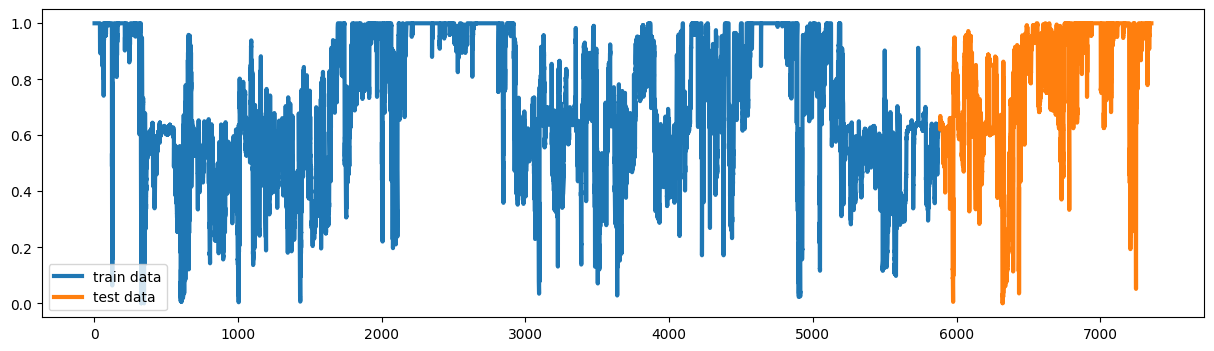

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.plot(X_train, y_train, lw=3, label='train data')
ax.plot(X_test, y_test,  lw=3, label='test data')
ax.legend(loc="lower left")
plt.show()

In [13]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# the variable that determines how many points 
# back into the past the model attempts to learn
look_back  = 120


batch_size = 64

# using 1 => using time steps
# anything over 1 => uses windowing
window_size = 1

# create a separate generator training and testing data
train_generator = TimeseriesGenerator(train_series, train_series,
                                      length        = look_back, 
                                      sampling_rate = 1,
                                      stride        = window_size,
                                      batch_size    = batch_size)

test_generator = TimeseriesGenerator(test_series, test_series,
                                      length        = look_back, 
                                      sampling_rate = 1,
                                      stride        = window_size,
                                      batch_size    = batch_size)

In [14]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Define model
model = Sequential()
model.add(LSTM(16, activation="relu", input_shape=(look_back, n_features), return_sequences=True))
#model.add(Dropout(0.2))
model.add(LSTM(8, activation="relu"))
#model.add(Dropout(0.2))
model.add(Dense(4, activation="relu"))
model.add(Dense(1))

# Compile with optimized settings
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss='mse')

# Callbacks
mc = ModelCheckpoint('best_model_friction.keras', monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
callback_list = [mc, es]

# Fit model with validation generator
model.fit(train_generator, epochs=150, verbose=1, validation_data=test_generator, callbacks=callback_list)

Epoch 1/150
918/918 [==============================] - 25s 26ms/step - loss: 0.1018 - val_loss: 0.0100
Epoch 2/150
918/918 [==============================] - 23s 25ms/step - loss: 0.0056 - val_loss: 0.0036
Epoch 3/150
918/918 [==============================] - 24s 26ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 4/150
918/918 [==============================] - 23s 25ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 5/150
918/918 [==============================] - 23s 25ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 6/150
918/918 [==============================] - 23s 25ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 7/150
918/918 [==============================] - 23s 25ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 8/150
918/918 [==============================] - 23s 25ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 9/150
918/918 [==============================] - 23s 25ms/step - loss: 9.7086e-04 - val_loss: 8.8412e-04
Epoch 10/150
918/918 [==============================] - 23s 25ms/

<Axes: >

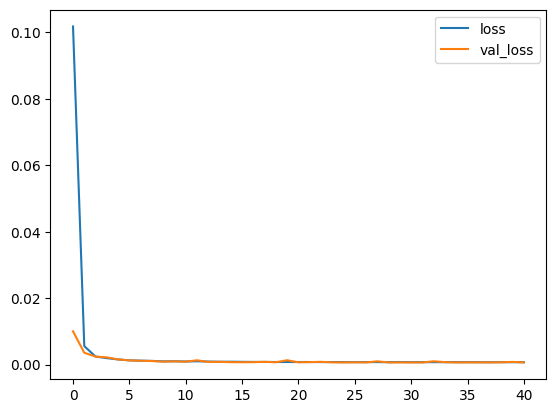

In [15]:
# the usual training metric visualization
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [16]:
# reload the best version of the model
from keras.models import load_model
model = load_model('best_model_friction.keras')

In [17]:
test_predictions = model.predict(test_generator)

228/228 [==============================] - 2s 6ms/step


In [18]:
# TensorFlow evaluation metrics
result = model.evaluate(train_generator)
print(f"Training loss: {result}")

# test loss
result = model.evaluate(test_generator)
print(f"Testing loss: {result}")

918/918 [==============================] - 5s 6ms/step - loss: 6.8775e-04
Training loss: 0.0006877454579807818
228/228 [==============================] - 1s 6ms/step - loss: 6.3198e-04
Testing loss: 0.000631975126452744


In [19]:
# MAPE score => less than 5% => very excellent result
# MAPE score => less than 10% => excellent result
# MAPE score => 10-20% => good result
# MAPE score => 20-50% => okay / reasonable / decent result

# negative MAPE score => the model constantly overestimates the values
# MAPE score over 100% => the model constantly underestimates the values

In [20]:
# let's make a separate copy of the test values
# so we can calculate some errors

actual_y_test = np.concatenate([y for x, y in test_generator])
errors = np.abs(actual_y_test - test_predictions)
mape = np.mean(errors / actual_y_test) * 100

# print out the MAPE-score
print("MAPE (mean average precision error):")
print(f"{round(mape, 2)} %")

# MAPE results sometimes produce weird results with synthetic data
# since synthetic data is often extremely predictable
# MAE - Mean average error
print("\nMAE")
print(round(metrics.mean_absolute_error(actual_y_test, test_predictions), 2), "units")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(actual_y_test, test_predictions), 2), "units^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(actual_y_test, test_predictions)), 2), "units")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(actual_y_test, test_predictions), 2))

MAPE (mean average precision error):
8.75 %

MAE
0.01 units

MSE
0.0 units^2

RMSE:
0.03 units

R-squared:
0.99


In [26]:
extrapolation = list()
seed_batch    = y_test[:look_back].reshape((1,look_back, n_features))
current_batch = seed_batch

# extrapolate the next 180 values
for i in range(12):
    predicted_value = model.predict(current_batch, verbose=None)[0]
    extrapolation.append(predicted_value) 
    current_batch = np.append(current_batch[:,1:,:],[[predicted_value]],axis=1)

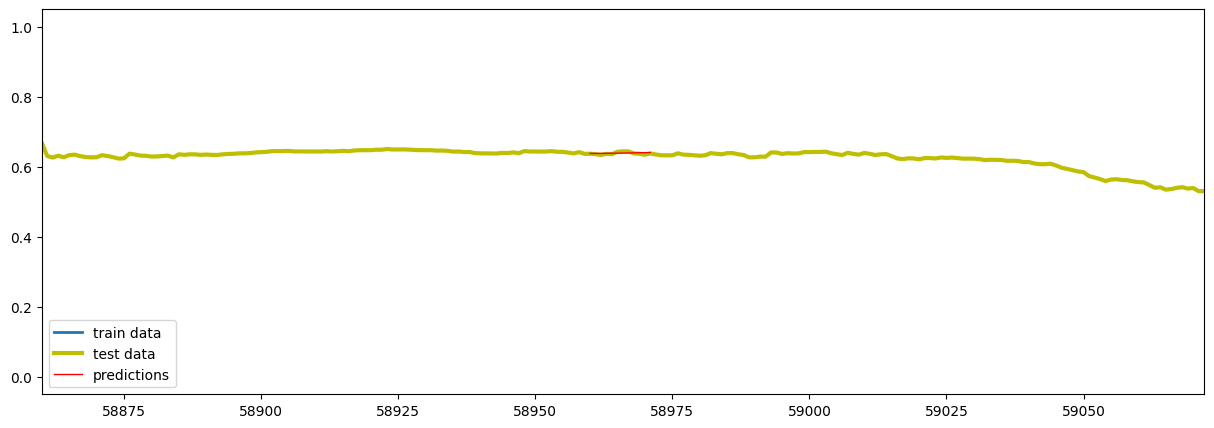

In [27]:
x1 = np.arange(0, len(y_train))
x2 = np.arange(len(y_train), len(y_train) + len(y_test))
x3 = np.arange(len(y_train) + look_back, len(y_train) + len(extrapolation) + look_back)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x1, y_train, lw=2, label='train data')
ax.plot(x2, y_test, lw=3, c='y', label='test data')
ax.plot(x3, extrapolation, lw=1, c='r', label='predictions')
ax.legend(loc="lower left")

zoom_start = len(y_train) + look_back - 100  # Start a bit before the extrapolation
zoom_end = len(y_train) + len(extrapolation) + look_back + 100  # End a bit after
ax.set_xlim(zoom_start, zoom_end)

plt.show()